In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, pca
import nglview as nv
# remote 先の settings で、"jupyter.widgetscriptsource" に "jsdelivr.com" を追加する

In [19]:
md_universe = mda.Universe("data/3poz_processed.pdb","trajectory.dcd")

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [20]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=49)

In [21]:
log_df = pd.read_csv("log.txt",sep="\t")
log_df.head()

,"#""Progress (%)""",Step,Potential Energy (kJ/mole),Temperature (K),Speed (ns/day)
0,0.2%,1000,-1.326184e+06,300.246139,0
1,0.4%,2000,-1.325356e+06,301.201670,239
2,0.6%,3000,-1.326890e+06,299.273191,239
3,0.8%,4000,-1.325540e+06,299.285215,236
4,1.0%,5000,-1.326875e+06,300.888374,236


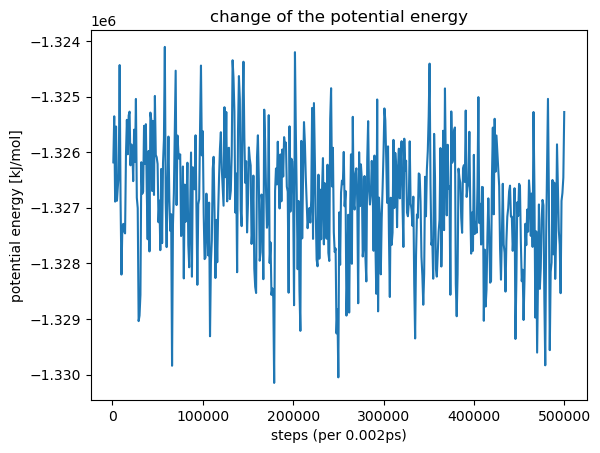

In [23]:
x = log_df["Step"]
y = log_df["Potential Energy (kJ/mole)"]
plt.plot(x,y)
plt.title("change of the potential energy")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("potential energy [kJ/mol]")
plt.show()

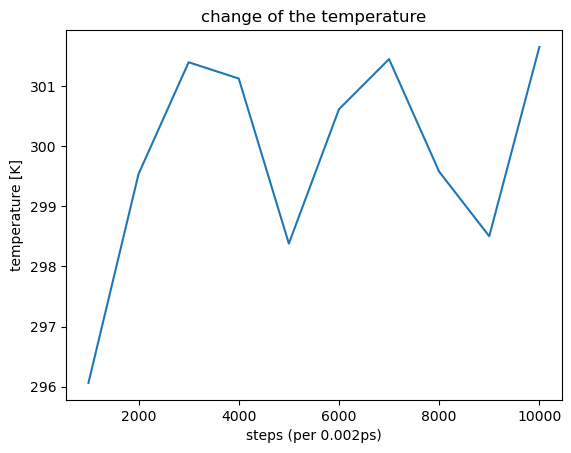

In [8]:
x = log_df["Step"]
y2 = log_df["Temperature (K)"]
plt.plot(x, y2)
plt.title("change of the temperature")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("temperature [K]")
plt.show()

---

## Trajectory analysis

In [24]:
print("example atoms : ", md_universe.atoms[-1])
print("protein atoms : ", len(md_universe.select_atoms("protein")))
print("backbone atoms : ", len(md_universe.select_atoms("backbone")))
print("CA atoms : ", len(md_universe.select_atoms("name CA")))

example atoms :  <Atom 80629: Cl of type Cl of resname CL, resid 10144 and segid D and altLoc >
protein atoms :  5254
backbone atoms :  1308
CA atoms :  327


In [25]:
# alignment
md_universe.trajectory[0]
alignment = align.AlignTraj(mobile=md_universe,reference=md_universe,select="protein",in_memory=True)
alignment.run()

### RMSD : referenceからのずれを観測

In [26]:
# 2点間のRMSD
md_universe.trajectory[0]
protein_first = md_universe.select_atoms("protein").positions
md_universe.trajectory[-1]
protein_last = md_universe.select_atoms("protein").positions
print(rms.rmsd(protein_first,protein_last))

2.1713402123413594


In [27]:
# トラジェクトリ全体のRMSD
md_universe.trajectory[0]
RMSD_analysis = rms.RMSD(md_universe,   # アラインメントを取るオブジェクト  
                     md_universe,     # アラインメントを合わせるリファレンスのオブジェクト  
                     select = "backbone",  # 計算対象を主鎖にする  
                     ref_frame = 0)   # リファレンスのフレームインデックス  
RMSD_analysis.run() 

In [28]:
print("type : ", type(RMSD_analysis.results.rmsd))
print("1st data : ", RMSD_analysis.results.rmsd[0])
print("total data number : ", len(RMSD_analysis.results.rmsd))

type :  <class 'numpy.ndarray'>
1st data :  [0.00000000e+00 0.00000000e+00 4.21906482e-07]
total data number :  50


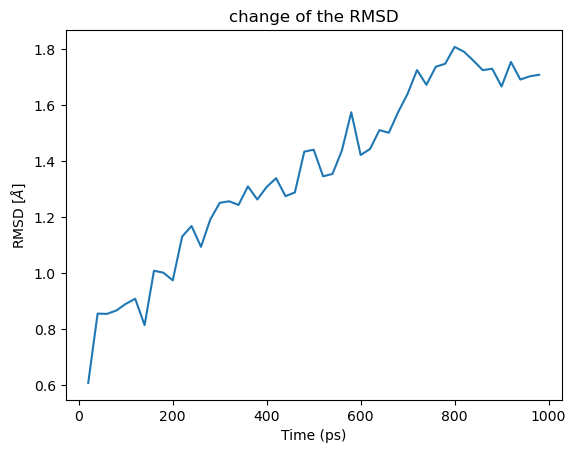

In [29]:
time_ps = RMSD_analysis.results.rmsd[1:,1]
backbone_RMSDs = RMSD_analysis.results.rmsd[1:,2]

plt.plot(time_ps, backbone_RMSDs)

plt.title("change of the RMSD")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD [$\AA$]")
plt.show()

/tmp/ipykernel_67675/562889988.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(RMSD_analysis.results.rmsd[1:,2], shade=True)


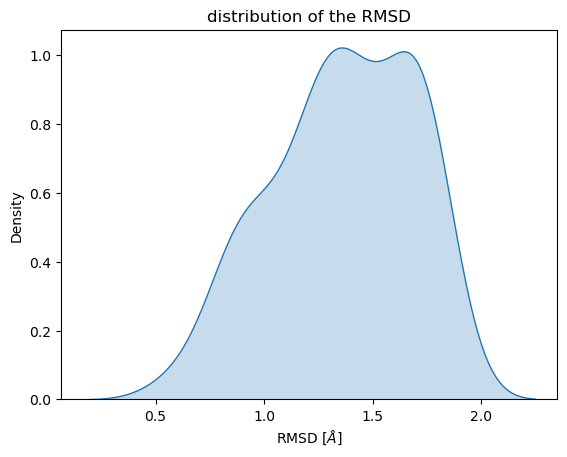

In [31]:
sns.kdeplot(RMSD_analysis.results.rmsd[1:,2], shade=True)
plt.title("distribution of the RMSD")
plt.xlabel("RMSD [$\AA$]")
plt.show()

### RMSF : 平衡状態に対するトラジェクトリの揺らぎ

In [32]:
C_alphas = md_universe.select_atoms("name CA")
RMSF_analysis = rms.RMSF(C_alphas)
RMSF_analysis.run()

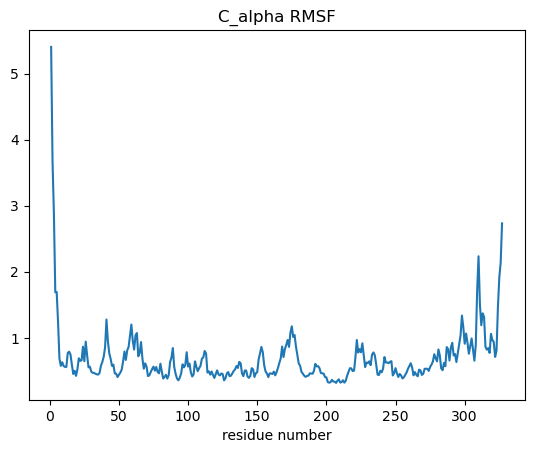

In [33]:
residue_numbers = C_alphas.resnums
plt.plot(residue_numbers, RMSF_analysis.results.rmsf)
plt.title("C_alpha RMSF")
plt.xlabel("residue number")
plt.show()

### 回転半径 : 分子中の質量の広がりを示す
フォールディングのシミュレーションでほどけ具合の指標になる

In [34]:
md_universe.trajectory[0]
C_alphas = md_universe.select_atoms("name CA")
C_alphas.radius_of_gyration()

20.066084840219894

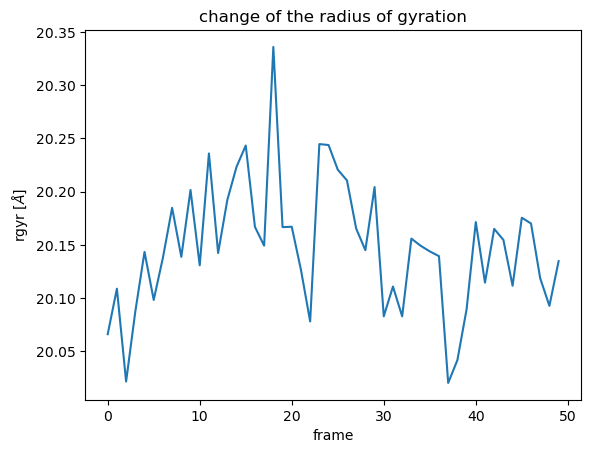

In [35]:
frame_list= []
rgyr_list = []
for ts in md_universe.trajectory:
    f = ts.frame
    rgyr = C_alphas.radius_of_gyration()
    frame_list.append(f)
    rgyr_list.append(rgyr)

plt.plot(frame_list, rgyr_list)
plt.title("change of the radius of gyration")
plt.xlabel("frame")
plt.ylabel("rgyr [$\AA$]")
plt.show()

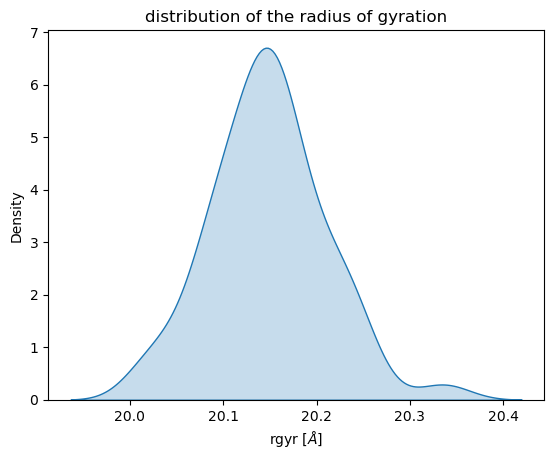

In [36]:
sns.kdeplot(rgyr_list, fill=True)
plt.title("distribution of the radius of gyration")
plt.xlabel("rgyr [$\AA$]")
plt.show()

### 主成分分析

In [38]:
# 各フレームで「原子数　×　3(xyz)」だけある　→　共分散の直交化で次元を落とす
Ca_pca = pca.PCA(md_universe,select="name CA")
Ca_pca.run()

In [39]:
components = Ca_pca.results.p_components
print(components.shape)

(981, 981)


In [40]:
print("1st varinace : ", Ca_pca.results.variance[0])
print("2nd varinace : ", Ca_pca.results.variance[1])
print("1st cumulative varinace : ", Ca_pca.results.cumulated_variance[0])
print("2nd cumulative varinace : ", Ca_pca.results.cumulated_variance[1])

1st varinace :  94.96293460305013
2nd varinace :  20.55810681131111
1st cumulative varinace :  0.4297290379708484
2nd cumulative varinace :  0.5227591817785874


>95% component number :  33


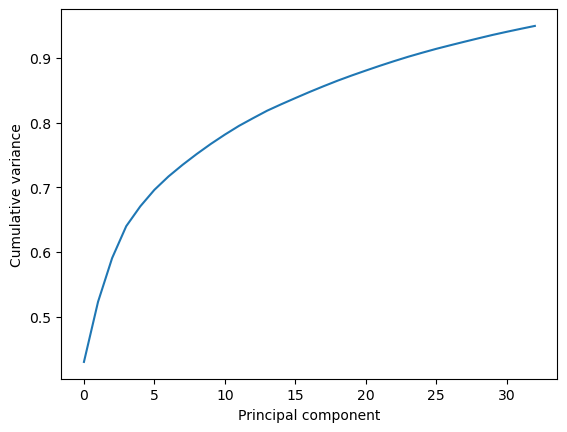

In [42]:
pc_95 = np.where(Ca_pca.results.cumulated_variance > 0.95)[0][0]
print(">95% component number : ", pc_95)
plt.plot(Ca_pca.results.cumulated_variance[:pc_95])
plt.xlabel("Principal component")
plt.ylabel("Cumulative variance")
plt.show()


In [43]:
transformed = Ca_pca.transform(md_universe.select_atoms("name CA"), n_components=3)
print("shape of the array : ", transformed.shape)

shape of the array :  (50, 3)


In [44]:
frame_time = md_universe.trajectory.dt
df = pd.DataFrame(transformed, columns=['PC1', 'PC2', 'PC3'])
df['Time (ps)'] = df.index * frame_time
df.head()

,PC1,PC2,PC3,Time (ps)
0,-16.098543,-4.791032,-0.405770,0.0
1,-14.095878,-5.058264,-1.289445,20.0
2,-14.654649,-6.397716,-3.843037,40.0
3,-14.637232,-5.565233,-4.822037,60.0
4,-13.820338,-5.368052,-2.475500,80.0


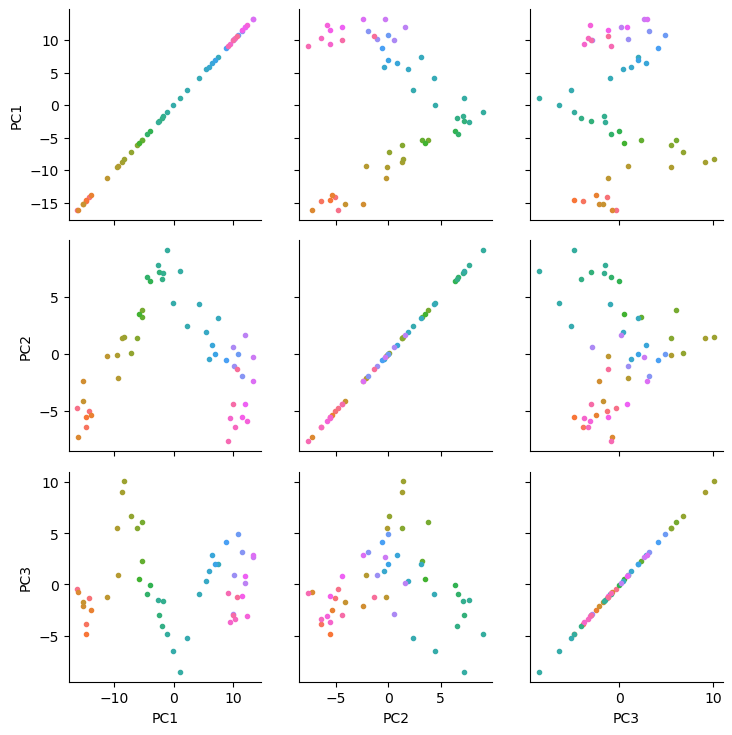

In [45]:
pair_grid_plot = sns.PairGrid(df, hue='Time (ps)')
pair_grid_plot.map(plt.scatter, marker='.')

In [49]:
# 動画に落とし込む
pc_1 = Ca_pca.results.p_components[:, 0]
pc_2 = Ca_pca.results.p_components[:,1]
weight_1 = transformed[:, 0]
weight_2 = transformed[:,1]
mean_coord = Ca_pca.mean
projected_1 = np.outer(weight_1,pc_1) + mean_coord.flatten()
projected_2 = np.outer(weight_2,pc_2) + mean_coord.flatten()
coordinates = projected_1.reshape(len(weight_1), -1, 3)
coordinates2 = projected_2.reshape(len(weight_2),-1,3)
print(coordinates.shape)

(50, 327, 3)


In [50]:
proj_univ = mda.Merge(md_universe.select_atoms("name CA"))
proj_univ.load_new(coordinates, order="fac")
view = nv.show_mdanalysis(proj_univ.atoms)
view

NGLWidget(max_frame=49)

In [51]:
proj_univ2 = mda.Merge(md_universe.select_atoms("name CA"))
proj_univ2.load_new(coordinates2, order="fac")
view = nv.show_mdanalysis(proj_univ2.atoms)
view

NGLWidget(max_frame=49)

### 相互相関解析 : 分子内の協同運動やドメイン構造の解析
平行な協同しか観測されないためタンパク質全体の議論は推奨されないが(PCA推奨)、タンパク質と小分子の相互作用なら実用的

In [90]:
coords = []
for i in range(50):
    md_universe.trajectory[i]
    coords.append(md_universe.select_atoms("name CA").positions)
coords = np.array(coords)
# [50, 327, 3]
m = np.mean(coords,axis=0) # <Ri> [327, 3]
dr = coords - m # Δri

In [128]:
cij = []
for i in tqdm(range(dr.shape[1])):
    temp = []
    for j in range(dr.shape[1]):
        dri = dr[:,i]
        drj = dr[:,j]
        upper = np.mean([np.dot(v,w) for v,w in zip(dri,drj)])
        dri2_m = np.mean([np.linalg.norm(v)**2 for v in dri],axis=0)
        drj2_m = np.mean([np.linalg.norm(v)**2 for v in drj],axis=0)
        lower = np.sqrt(dri2_m * drj2_m)
        temp.append(upper / lower)
    cij.append(temp)

  0%|          | 0/327 [00:00<?, ?it/s]

<Axes: >

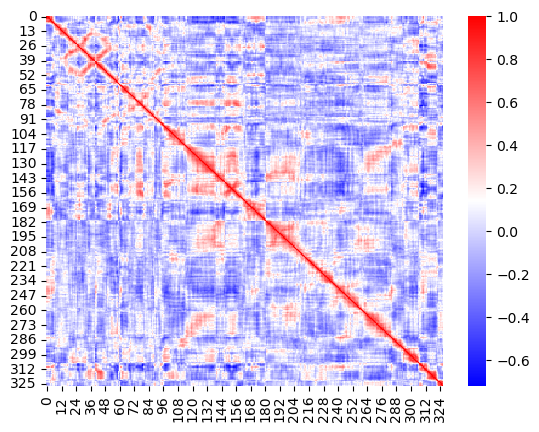

In [131]:
sns.heatmap(cij,cmap="bwr")